In [1]:
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, Dataset, DataLoader

from tqdm.notebook import tqdm
import numpy as np

from aijack.defense import VIB, KL_between_normals, mib_loss

In [2]:
dim_z = 256
beta = 1e-3
batch_size = 100
samples_amount = 15
num_epochs = 1

In [3]:
train_data = MNIST("MNIST/.", download=True, train=True)
train_dataset = TensorDataset(
    train_data.train_data.view(-1, 28 * 28).float() / 255, train_data.train_labels
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

test_data = MNIST("MNIST/.", download=True, train=False)
test_dataset = TensorDataset(
    test_data.test_data.view(-1, 28 * 28).float() / 255, test_data.test_labels
)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/home/codespace/.python/current/lib/python3.10/site-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
encoder = nn.Sequential(
    nn.Linear(in_features=784, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=2 * dim_z),
)
decoder = nn.Linear(in_features=dim_z, out_features=10)

In [5]:
net = VIB(encoder, decoder, dim_z, num_samples=samples_amount)

# Train the victim
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

net = net.to(device)
opt = torch.optim.Adam(net.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(opt, gamma=0.97)

In [6]:
import time

for epoch in range(num_epochs):
    loss_by_epoch = []
    accuracy_by_epoch = []
    I_ZX_bound_by_epoch = []
    I_ZY_bound_by_epoch = []

    loss_by_epoch_test = []
    accuracy_by_epoch_test = []
    I_ZX_bound_by_epoch_test = []
    I_ZY_bound_by_epoch_test = []

    if epoch % 2 == 0 and epoch > 0:
        scheduler.step()

    for x_batch, y_batch in tqdm(train_loader):
        x_batch = x_batch
        y_batch = y_batch

        y_pred, result_dict = net(x_batch)
        sampled_y_pred = result_dict["sampled_decoded_outputs"]
        p_z_given_x_mu = result_dict["p_z_given_x_mu"]
        p_z_given_x_sigma = result_dict["p_z_given_x_sigma"]

        approximated_z_mean = torch.zeros_like(p_z_given_x_mu)
        approximated_z_sigma = torch.ones_like(p_z_given_x_sigma)

        loss, I_ZY_bound, I_ZX_bound = mib_loss(
            y_batch,
            sampled_y_pred,
            p_z_given_x_mu,
            p_z_given_x_sigma,
            approximated_z_mean,
            approximated_z_sigma,
            beta=beta,
        )

        prediction = torch.max(y_pred, dim=1)[1]
        accuracy = torch.mean((prediction == y_batch).float())

        loss.backward()
        opt.step()
        opt.zero_grad()

        I_ZX_bound_by_epoch.append(I_ZX_bound.item())
        I_ZY_bound_by_epoch.append(I_ZY_bound.item())

        loss_by_epoch.append(loss.item())
        accuracy_by_epoch.append(accuracy.item())

    for x_batch, y_batch in tqdm(test_loader):
        x_batch = x_batch
        y_batch = y_batch

        y_pred, result_dict = net(x_batch)
        sampled_y_pred = result_dict["sampled_decoded_outputs"]
        p_z_given_x_mu = result_dict["p_z_given_x_mu"]
        p_z_given_x_sigma = result_dict["p_z_given_x_sigma"]

        approximated_z_mean = torch.zeros_like(p_z_given_x_mu)
        approximated_z_sigma = torch.ones_like(p_z_given_x_sigma)

        loss, I_ZY_bound, I_ZX_bound = mib_loss(
            y_batch,
            sampled_y_pred,
            p_z_given_x_mu,
            p_z_given_x_sigma,
            approximated_z_mean,
            approximated_z_sigma,
            beta=beta,
        )

        prediction = torch.max(y_pred, dim=1)[1]
        accuracy = torch.mean((prediction == y_batch).float())

        I_ZX_bound_by_epoch_test.append(I_ZX_bound.item())
        I_ZY_bound_by_epoch_test.append(I_ZY_bound.item())

        loss_by_epoch_test.append(loss.item())
        accuracy_by_epoch_test.append(accuracy.item())

    print(
        "epoch",
        epoch,
        "loss",
        np.mean(loss_by_epoch_test),
        "prediction",
        np.mean(accuracy_by_epoch_test),
    )

    print(
        "I_ZX_bound",
        np.mean(I_ZX_bound_by_epoch_test),
        "I_ZY_bound",
        np.mean(I_ZY_bound_by_epoch_test),
    )

  0%|          | 0/600 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

epoch 0 loss 0.2888427330553532 prediction 0.9423000019788742
I_ZX_bound 68.37141117095948 I_ZY_bound 0.22047131903469563


In [7]:
from aijack.attack import GradientInversion_Attack

y_pred, result_dict = net(x_batch[:1])
sampled_y_pred = result_dict["sampled_decoded_outputs"]
p_z_given_x_mu = result_dict["p_z_given_x_mu"]
p_z_given_x_sigma = result_dict["p_z_given_x_sigma"]

approximated_z_mean = torch.zeros_like(p_z_given_x_mu)
approximated_z_sigma = torch.ones_like(p_z_given_x_sigma)


loss, I_ZY_bound, I_ZX_bound = mib_loss(
    y_batch[:1],
    sampled_y_pred,
    p_z_given_x_mu,
    p_z_given_x_sigma,
    approximated_z_mean,
    approximated_z_sigma,
    beta=beta,
)

received_gradients = torch.autograd.grad(loss, net.parameters())
received_gradients = [cg.detach() for cg in received_gradients]
received_gradients = [cg for cg in received_gradients]


In [8]:
net.eval()
cpl_attacker = GradientInversion_Attack(
    net,
    (784,),
    lr=0.3,
    log_interval=50,
    optimizer_class=torch.optim.LBFGS,
    distancename="l2",
    optimize_label=False,
    num_iteration=10,
)

  0%|          | 0/5 [00:00<?, ?it/s]

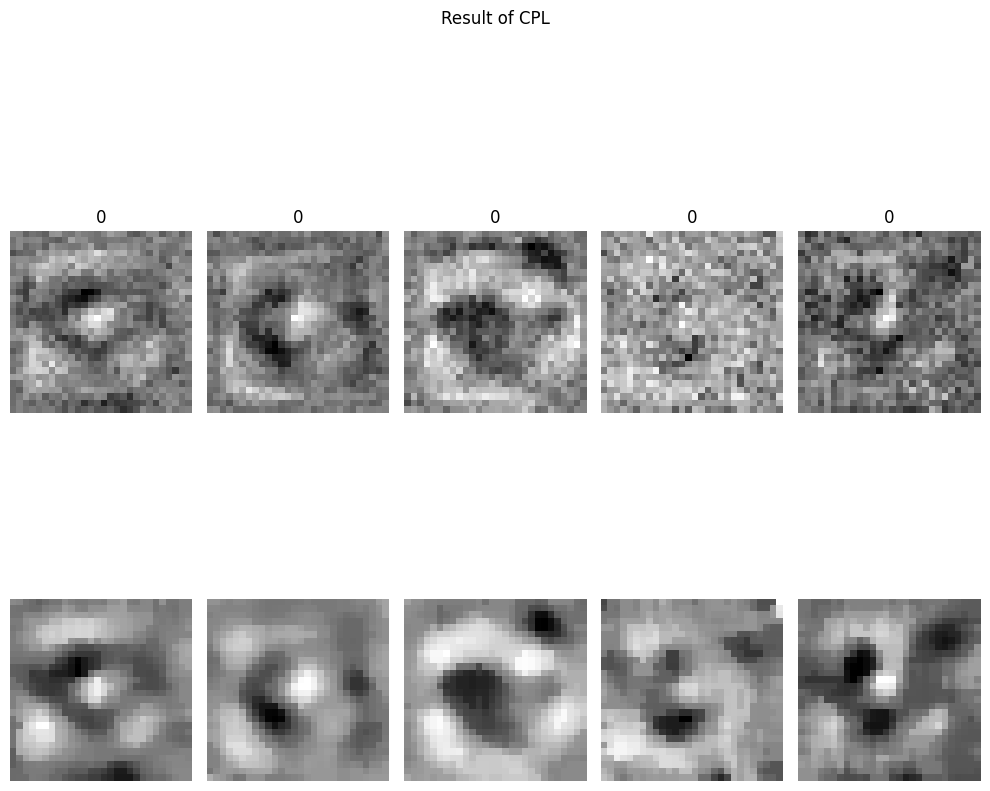

: 

In [9]:
from matplotlib import pyplot as plt
import cv2


num_seeds = 5
fig = plt.figure(figsize=(10,10))
for s in tqdm(range(num_seeds)):
    cpl_attacker.reset_seed(s)
    try:
        result = cpl_attacker.attack(received_gradients)
        ax1 = fig.add_subplot(2, num_seeds, s + 1)
        ax1.imshow(result[0].cpu().detach().numpy()[0].reshape(28, 28), cmap="gray")
        ax1.axis("off")
        ax1.set_title(torch.argmax(result[1]).cpu().item())
        ax2 = fig.add_subplot(2, num_seeds, num_seeds + s + 1)
        ax2.imshow(
            cv2.medianBlur(result[0].cpu().detach().numpy()[0].reshape(28, 28), 5),
            cmap="gray",
        )
        ax2.axis("off")
    except:
        pass
plt.suptitle("Result of CPL")
plt.tight_layout()
plt.show()